In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dfM2 = pd.read_csv('datasets/SA_Aqar.csv')
dfM2.head()

,city,district,front,size,property_age,bedrooms,bathrooms,livingrooms,kitchen,garage,...,roof,pool,frontyard,basement,duplex,stairs,elevator,fireplace,price,details
0,الرياض,حي العارض,شمال,250,0,5,5,1,1,1,...,0,0,1,0,1,1,0,0,80000,للايجار فيلا دبلكس في موقع ممتاز جدا بالقرب من...
1,الرياض,حي القادسية,جنوب,370,0,4,5,2,1,1,...,0,0,1,0,0,1,0,0,60000,*** فيلا درج مع الصالة جديدة ***\n\nعبارة عن م...
2,الرياض,حي القادسية,جنوب,380,0,4,5,1,1,1,...,1,0,1,0,0,1,0,0,60000,فيلا للايجار درج داخلي مشب خارجي مجلس مقلط وصا...
3,الرياض,حي المعيزلة,غرب,250,0,5,5,3,0,1,...,0,0,1,0,0,0,0,0,55000,فيلا للايجار جديده لن تستخدم ش...
4,الرياض,حي العليا,غرب,400,11,7,5,2,1,1,...,1,0,1,0,1,1,0,0,70000,فيلا للايجار حي العليا \n\nالارضي مجالس وغرفتي...


In [3]:
to_replace = {"شمال": "north", "جنوب": "south", "غرب": "west","شرق":"east", "شمال شرقي":"northeast","جنوب شرقي":"south east"
             ,"3 شوارع":"street", "جنوب غربي":"southwest","شمال غربي":"northwest","4 شوارع":"street"}
dfM2.replace(to_replace=to_replace, inplace=True)
dfM2.drop(columns=['city','district','details'], inplace=True)
dfM2.head()

,front,size,property_age,bedrooms,bathrooms,livingrooms,kitchen,garage,driver_room,maid_room,...,ac,roof,pool,frontyard,basement,duplex,stairs,elevator,fireplace,price
0,north,250,0,5,5,1,1,1,0,1,...,0,0,0,1,0,1,1,0,0,80000
1,south,370,0,4,5,2,1,1,0,0,...,0,0,0,1,0,0,1,0,0,60000
2,south,380,0,4,5,1,1,1,1,1,...,0,1,0,1,0,0,1,0,0,60000
3,west,250,0,5,5,3,0,1,1,1,...,0,0,0,1,0,0,0,0,0,55000
4,west,400,11,7,5,2,1,1,1,1,...,0,1,0,1,0,1,1,0,0,70000


In [4]:
#dfM2.drop(index= dfM2['size'].nlargest(10).index, inplace=True)
to_replace = {"north":1, "south":2,"west":3,"east":4,"northeast":5,"south east":6 , "southwest":7,"northwest":8,"street":9}
dfM2.replace(to_replace=to_replace, inplace=True)

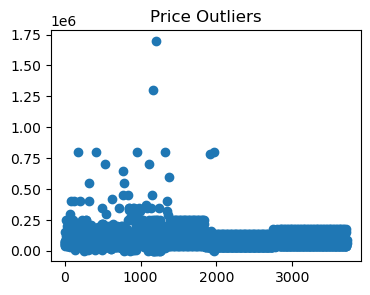

In [5]:
plt.figure(figsize=(4, 3)) 
plt.scatter(x=range(len(dfM2['price'])), y=dfM2['price'])
plt.title("Price Outliers")
plt.show()

In [6]:
from sklearn.ensemble import IsolationForest

X = dfM2[['price']]

iso_forest = IsolationForest(contamination=0.05)  # Adjust the contamination parameter based on your data

# Fit the model and predict outliers
outliers = iso_forest.fit_predict(X)

# Filter out the outliers
dfM2 = dfM2[outliers != -1]

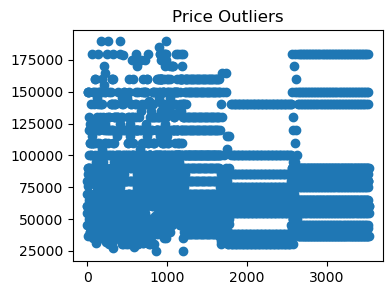

In [7]:
plt.figure(figsize=(4, 3)) 
plt.scatter(x=range(len(dfM2['price'])), y=dfM2['price'])
plt.title("Price Outliers")
plt.show()

In [8]:
dfM2.drop(index= dfM2['size'].nlargest(2).index, inplace=True)

In [9]:
dfM2_copy = dfM2.copy()  # Make a copy of dfM2

# Filter the rows where "size" is greater than 500
above_500 = dfM2_copy[dfM2_copy['size'] > 500]

# Calculate the minimum and maximum sizes in this range
min_size = above_500['size'].min()
max_size = above_500['size'].max()

# Rescale the sizes to the new 0-500 m² scale
pd.options.mode.chained_assignment = None  # Suppress the warning
above_500['rescaled_size'] = (above_500['size'] - min_size) / (max_size - min_size) * 500
pd.options.mode.chained_assignment = 'warn'  # Revert the warning state

# Calculate the price per square meter for each apartment
pd.options.mode.chained_assignment = None  # Suppress the warning
above_500['price_per_meter'] = above_500['price'] / above_500['size']
pd.options.mode.chained_assignment = 'warn'  # Revert the warning state

# Adjust the prices based on the new rescaled size
pd.options.mode.chained_assignment = None  # Suppress the warning
above_500['adjusted_price'] = above_500['rescaled_size'] * above_500['price_per_meter']
pd.options.mode.chained_assignment = 'warn'  # Revert the warning state

# Drop the original 'size' and 'price' columns
above_500 = above_500.drop(columns=['size', 'price'])

# Rename the rescaled columns
above_500 = above_500.rename(columns={'rescaled_size': 'size', 'adjusted_price': 'price'})

above_500.drop(columns=['price_per_meter'], inplace=True)
dfM2 = dfM2[dfM2['size'] <= 500]
dfM2 = pd.concat([dfM2, above_500], ignore_index=True)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df1 = dfM2.copy()

features = df1.drop('price', axis=1)  
target = df1['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=42 )

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2score = r2_score(y_test, y_pred)
print('R^2 Score:', r2score)

MAE: 19010.131807314756
MSE: 660799675.696611
R^2 Score: 0.5464152316342483


In [12]:
def correlation_trashold(df):
    correlation_df = df.corr(numeric_only=True)
    threshold = 0.1
    filtered = np.abs(correlation_df['price']) > threshold
    wanted_features = correlation_df.columns[filtered].tolist()
    return wanted_features

wanted_features = correlation_trashold(df1)
wanted_features

['front',
 'size',
 'property_age',
 'bedrooms',
 'livingrooms',
 'kitchen',
 'driver_room',
 'maid_room',
 'ac',
 'pool',
 'basement',
 'duplex',
 'stairs',
 'fireplace',
 'price']

In [13]:
df = df1.loc[:, wanted_features]

In [14]:
features = df.drop('price', axis=1)  
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2score = r2_score(y_test, y_pred)
print('R^2 Score:', r2score)

MAE: 19239.522564752446
MSE: 622819102.6189015
R^2 Score: 0.5737689343858832


In [16]:
def correlation_trashold(df):
    correlation_df = df.corr(numeric_only=True)
    threshold = 0.15
    filtered = np.abs(correlation_df['price']) > threshold
    wanted_features = correlation_df.columns[filtered].tolist()
    return wanted_features

wanted_features = correlation_trashold(df1)
wanted_features

['size',
 'bedrooms',
 'livingrooms',
 'driver_room',
 'maid_room',
 'ac',
 'pool',
 'basement',
 'duplex',
 'fireplace',
 'price']

In [17]:
df = df1.loc[:, wanted_features]

In [18]:
features = df.drop('price', axis=1)  
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2score = r2_score(y_test, y_pred)
print('R^2 Score:', r2score)

MAE: 17892.646923005956
MSE: 583735945.9627665
R^2 Score: 0.6071635700710253


In [20]:
from sklearn.preprocessing import PowerTransformer

def power_transformer(df):
    columns_to_concat = [col for col in df.columns if len(df[col].unique()) <= 2]
    columns_to_transform = [col for col in df.columns if len(df[col].unique()) > 2]
    pt = PowerTransformer(method='box-cox')
    transformed_data = pt.fit_transform(df[columns_to_transform] + 0.000001)
    transformed_df = pd.DataFrame(transformed_data, columns=columns_to_transform, index=df.index)
    result_df = pd.concat([transformed_df] + [df[columns_to_concat]], axis=1)
    return result_df


df1 = dfM2.copy()
power_transformer_df = pd.DataFrame(power_transformer(df1), columns=df1.columns)

In [21]:
features = power_transformer_df.drop('price', axis=1)  
target = power_transformer_df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2score = r2_score(y_test, y_pred)
print('R^2 Score:', r2score)

MAE: 0.4809647793575781
MSE: 0.3921778025667252
R^2 Score: 0.5785158153867955


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the data for test and train sets
def split_test_train_set(data):
    x, y = data.drop('price', axis=1), data['price']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
    return x_train, x_test, y_train, y_test

In [24]:
x_train, x_test, y_train, y_test = split_test_train_set(power_transformer_df)

model = RandomForestRegressor(n_estimators=100, random_state=42)  
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', mse)

r2score = r2_score(y_test, y_pred)
print('R-squared (R^2) Score:', r2score)

Mean Absolute Error (MAE): 0.16251522558208278
Mean Squared Error (MSE): 0.13236875677092794
R-squared (R^2) Score: 0.8504902715316777


In [28]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

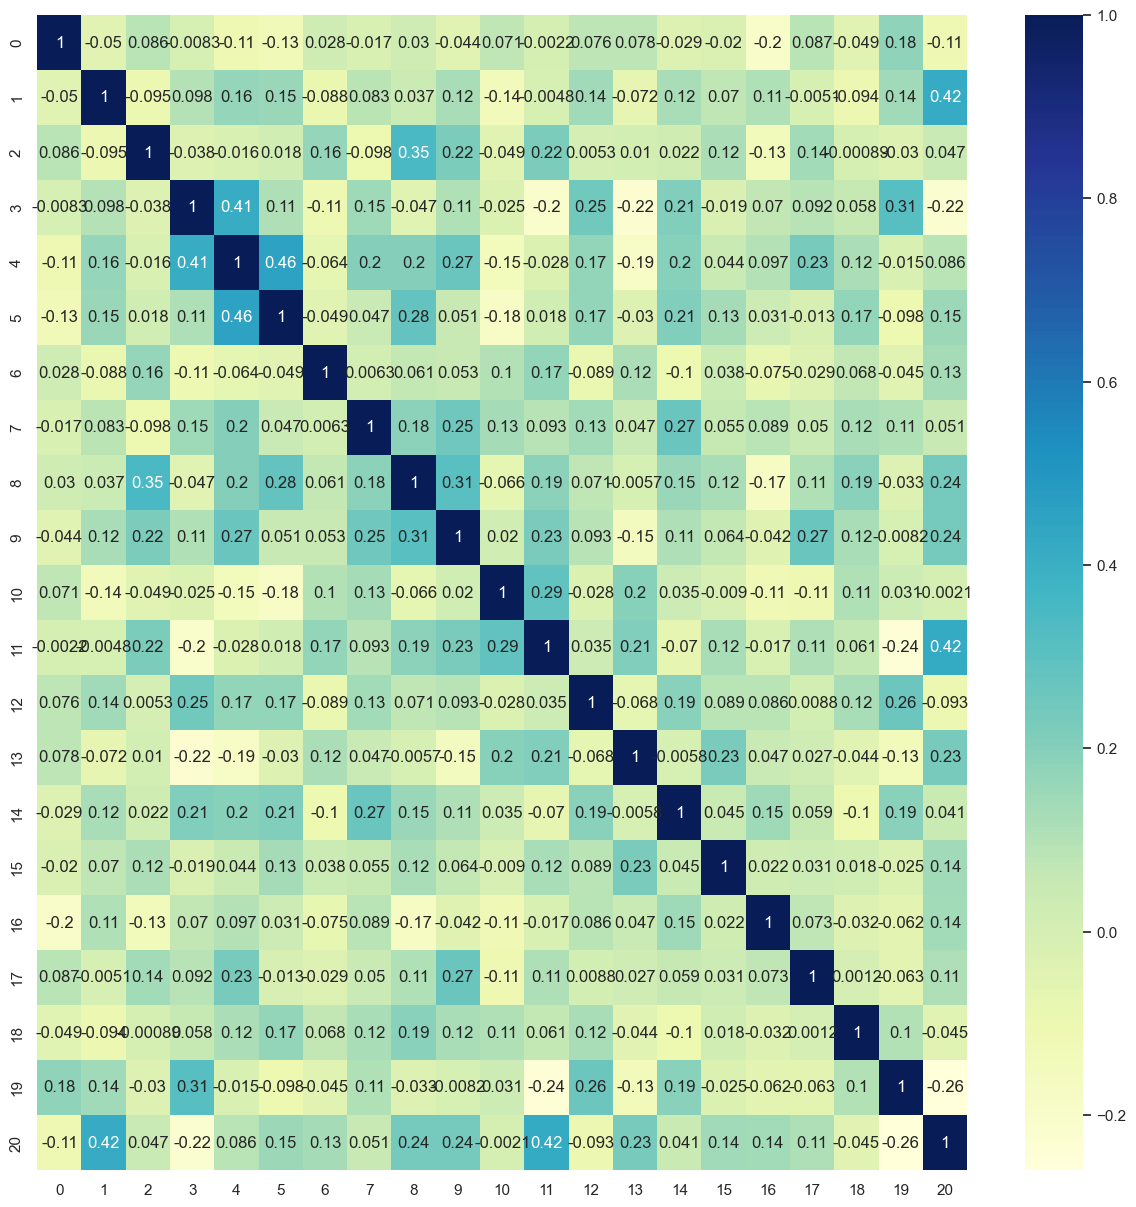